Ella Archie (earchie@calpoly.edu)

Jadin Stewart (jsstewar@calpoly.edu)

GSB S521 - 01

March 16th, 2023

# <center> Snapchat Covid Forecasting  </center>

In [ ]:
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import datetime as dt
from prophet import Prophet
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as st
from IPython import display
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/covid data.xlsx" "covid data.xlsx"
!cp "/content/drive/MyDrive/Colab Notebooks/snapchat_covid.png" "snapchat_covid.png"
!cp "/content/drive/MyDrive/Colab Notebooks/usage_pre_covid_nordic.csv" "usage_pre_covid_nordic.csv"

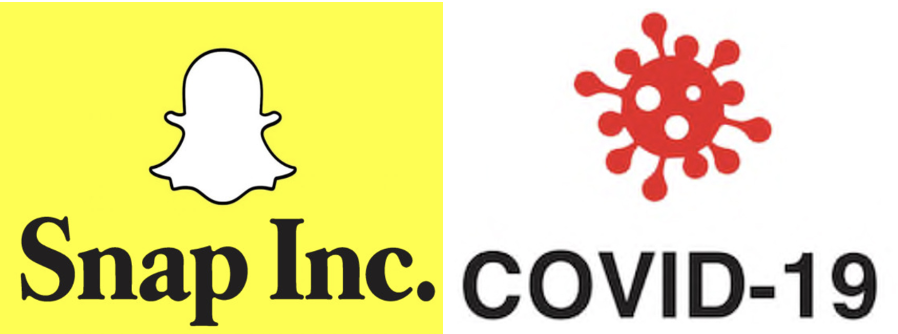

In [ ]:
display.Image("snapchat_covid.png")

# <center> Introduction </center>

At the beginning of the pandemic, many people believed Covid-19 would only be around for a couple weeks. The uncertainty of how quickly and easily the virus would spread made it very difficult for companies to anticipate how business would be impacted. In this notebook, we will be predicting and forecasting Snapchat Daily Active Users in the first and second quarter of 2020.

# <center> Data </center>

We collected data from two places for this analysis. First, Professor Pierce provided us with Snaps pre-covid daily active user data from the Nordic region. Second, we collected data on covid cases in the Nordic region from the Our World in Data.



Snapchat Data: "usage_pre_covid_nordic.csv"

Covid Data: https://ourworldindata.org/explorers/coronavirus-data-explorer?uniformYAxis=0&pickerSort=desc&pickerMetric=location&Metric=Cases+and+deaths&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=SWE~NOR~DNK

### Snapchat Data

In [ ]:
my_data = pd.read_csv("usage_pre_covid_nordic.csv")

In [ ]:
my_data.rename(columns = {'event_date':'Event_Date','country':'Country','age':'Age',
                          'top_device':'Top_Device','gender':'Gender',
                          'APP_APPLICATION_OPEN_UU':'Daily_Active_Users',
                          'APP_APPLICATION_OPEN_COUNT':'Daily_Total_Users',
                          'DIRECT_SNAP_CREATE_UU':'Daily_Unique_Snaps',
                          'DIRECT_SNAP_CREATE_COUNT':'Daily_Total_Snaps',
                          'DIRECT_SNAP_SEND_UU':'Daily_Unique_Sends',
                          'DIRECT_SNAP_SEND_COUNT':'Daily_Total_Sends',
                          'STORY_SNAP_POST_UU':'Daily_Unique_Stories',
                          'STORY_SNAP_POST_COUNT':'Daily_Total_Stories'}, inplace = True)

In [ ]:
my_data['Event_Date'] = pd.to_datetime(my_data['Event_Date'])
my_data['Month_Year'] = my_data['Event_Date'].dt.to_period('M')
my_data['Gender'] = np.where(my_data['Gender'].isin(['female', 'male']), my_data['Gender'], 'unknown')

In [ ]:
my_data.head(5)

,Event_Date,Country,Age,Top_Device,Gender,Daily_Active_Users,Daily_Total_Users,Daily_Unique_Snaps,Daily_Total_Snaps,Daily_Unique_Sends,Daily_Total_Sends,Daily_Unique_Stories,Daily_Total_Stories,Month_Year
0,2019-09-11,DK,2018.000,Android,female,287,6012,213,4093,195,3029,13,24,2019-09
1,2019-03-29,SE,2018.000,Android,male,2515,87650,2033,63670,1946,53452,334,838,2019-03
2,2019-07-09,DK,2018.000,Android,female,545,13753,431,9964,402,7196,75,254,2019-07
3,2019-02-08,DK,2018.000,Android,female,1258,28657,953,18622,893,14228,135,416,2019-02
4,2019-10-14,SE,2018.000,Android,female,237,5173,180,3298,172,2446,18,39,2019-10


In [ ]:
my_data2 = my_data.groupby(['Event_Date'], as_index = False).sum()
my_data2.head(5)

,Event_Date,Age,Daily_Active_Users,Daily_Total_Users,Daily_Unique_Snaps,Daily_Total_Snaps,Daily_Unique_Sends,Daily_Total_Sends,Daily_Unique_Stories,Daily_Total_Stories
0,2019-01-01,220800.000,7012787,222945271,4258056,231957589,3844829,175518694,831902,3823032
1,2019-01-02,213306.000,6522305,226955941,4228556,235948503,3874614,176458803,771048,3794343
2,2019-01-03,217389.000,6457837,221509065,4225903,219938079,3874301,164118218,760498,3544998
3,2019-01-04,212886.000,6529505,234288048,4373786,229916458,4012875,171362972,836626,3955857
4,2019-01-05,214801.000,6650731,245167743,4529193,243428203,4138549,180855835,965327,4587028


### Covid Data

In [ ]:
covid_df = pd.read_excel("covid data.xlsx")
covid_df.tail(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
3277,SWE,Europe,Sweden,2022-12-27,2672531.000,650,1799.143,22084.000,53,52.571,...,18.900,NaN,2.220,82.800,0.945,10549349,NaN,NaN,NaN,NaN
3278,SWE,Europe,Sweden,2022-12-28,2673136.000,605,1635.143,22138.000,54,54.000,...,18.900,NaN,2.220,82.800,0.945,10549349,NaN,NaN,NaN,NaN
3279,SWE,Europe,Sweden,2022-12-29,2674479.000,1343,1459.571,22190.000,52,55.143,...,18.900,NaN,2.220,82.800,0.945,10549349,NaN,NaN,NaN,NaN
3280,SWE,Europe,Sweden,2022-12-30,2676668.000,2189,1386.143,22246.000,56,56.143,...,18.900,NaN,2.220,82.800,0.945,10549349,NaN,NaN,NaN,NaN
3281,SWE,Europe,Sweden,2022-12-31,2678465.000,1797,1318.429,22287.000,41,54.143,...,18.900,NaN,2.220,82.800,0.945,10549349,NaN,NaN,NaN,NaN


In [ ]:
covid_df2 = covid_df.groupby(['date'], as_index = False).sum()
covid_df2['date'] = pd.to_datetime(covid_df2['date'])
covid_df2.tail(5)

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
1089,2022-12-27,7530318.000,1626,3296.572,34626.000,64,75.714,1099831.558,229.443,427.802,...,58.400,0.000,8.320,246.100,2.842,21865932,0.000,0.000,0.000,0.000
1090,2022-12-28,7532012.000,1694,3073.143,34693.000,67,77.571,1100077.502,245.944,402.051,...,58.400,0.000,8.320,246.100,2.842,21865932,0.000,0.000,0.000,0.000
1091,2022-12-29,7535034.000,3022,2829.428,34756.000,63,79.143,1100493.269,415.767,373.705,...,58.400,0.000,8.320,246.100,2.842,21865932,0.000,0.000,0.000,0.000
1092,2022-12-30,7538791.000,3757,2700.714,34824.000,68,80.286,1100970.544,477.275,357.355,...,58.400,0.000,8.320,246.100,2.842,21865932,0.000,0.000,0.000,0.000
1093,2022-12-31,7542050.000,3259,2557.715,34877.000,53,78.571,1101392.204,421.660,338.155,...,58.400,0.000,8.320,246.100,2.842,21865932,0.000,0.000,0.000,0.000


# <center> Time Series Plot </center>

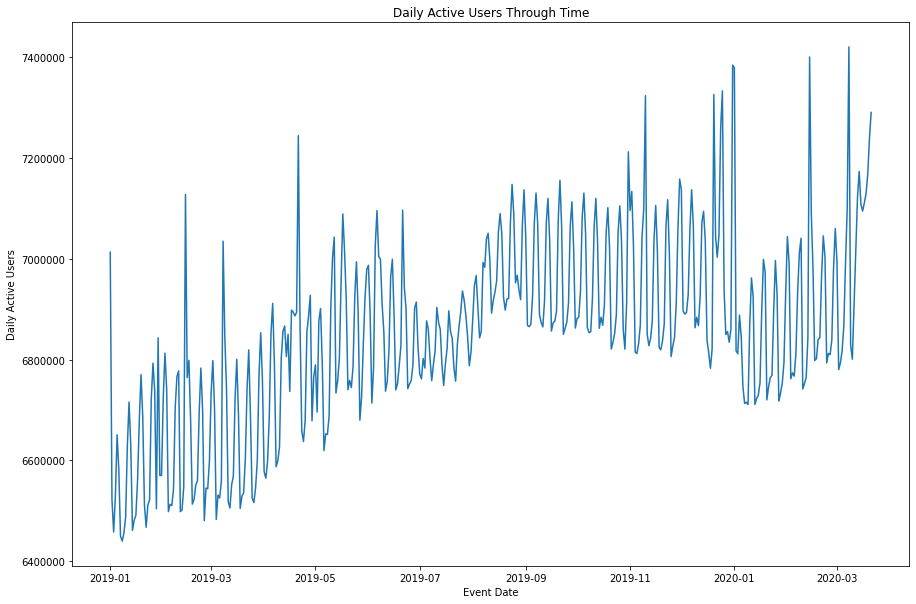

In [ ]:
my_plot = my_data.groupby(['Event_Date'], as_index = False).sum()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.lineplot(x='Event_Date', y='Daily_Active_Users', data = my_plot, ax=ax)
ax.set_xlabel('Event Date')
ax.set_ylabel('Daily Active Users')
ax.set_title('Daily Active Users Through Time')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# <center> Quarter 1 Prediction </center>

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/_a4zkuly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/w14o4i9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88412', 'data', 'file=/tmp/tmplrk6p3ap/_a4zkuly.json', 'init=/tmp/tmplrk6p3ap/w14o4i9s.json', 'output', 'file=/tmp/tmplrk6p3ap/prophet_model_qs6pfsv/prophet_model-20230316214021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


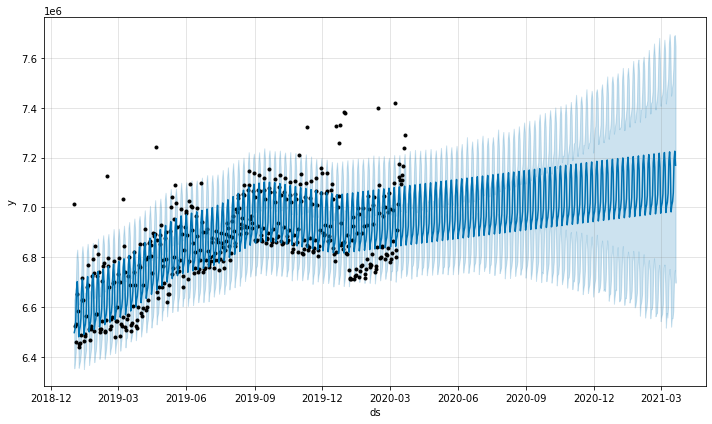

In [ ]:
my_data2.rename(columns = {'Event_Date':'ds','Daily_Active_Users':'y'}, inplace = True)

m = Prophet(seasonality_mode = 'multiplicative')
m.fit(my_data2)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)
m.plot(forecast);

In [ ]:
my_data2_q1 = my_data2[my_data2['ds'].between("2020-01-01", "2020-03-21")]
avg_1 = my_data2_q1["y"].mean() * 81
forecast_q1 = forecast[forecast['ds'].between("2020-03-22", "2020-03-31")]
avg_2 = forecast_q1["yhat"].mean() * 10
(avg_1 + avg_2)/91

6916667.697551572

Average Q1'2020 DAU Prediction: 6,916,667.70

# <center> Quarter 2 Prediction </center>

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/9fkd71t2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/kbuv3uhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5370', 'data', 'file=/tmp/tmplrk6p3ap/9fkd71t2.json', 'init=/tmp/tmplrk6p3ap/kbuv3uhx.json', 'output', 'file=/tmp/tmplrk6p3ap/prophet_modelodgoy36t/prophet_model-20230316214021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


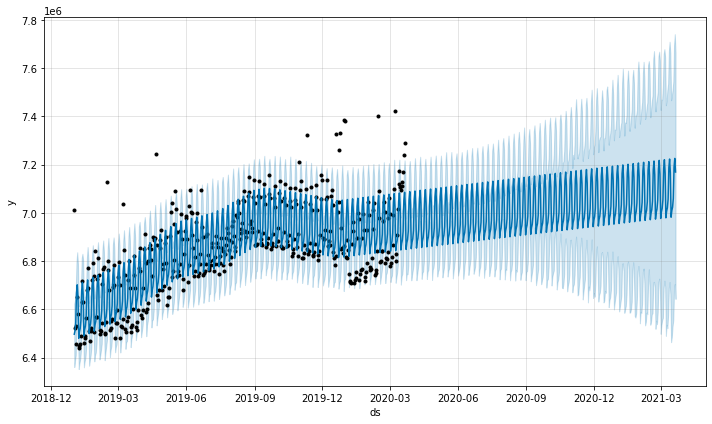

In [ ]:
m = Prophet(seasonality_mode = 'multiplicative')
m.fit(my_data2)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)
m.plot(forecast);

In [ ]:
forecast_q2 = forecast[forecast['ds'].between("2020-04-01", "2020-6-30")]
forecast_q2["yhat"].mean()

6977934.722336376

Q2'2020 DAU Lower Bound: 6,977,934.72

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/x13o7bq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrk6p3ap/ztf1p9xr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15675', 'data', 'file=/tmp/tmplrk6p3ap/x13o7bq3.json', 'init=/tmp/tmplrk6p3ap/ztf1p9xr.json', 'output', 'file=/tmp/tmplrk6p3ap/prophet_modelzn6gcdc8/prophet_model-20230316214022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


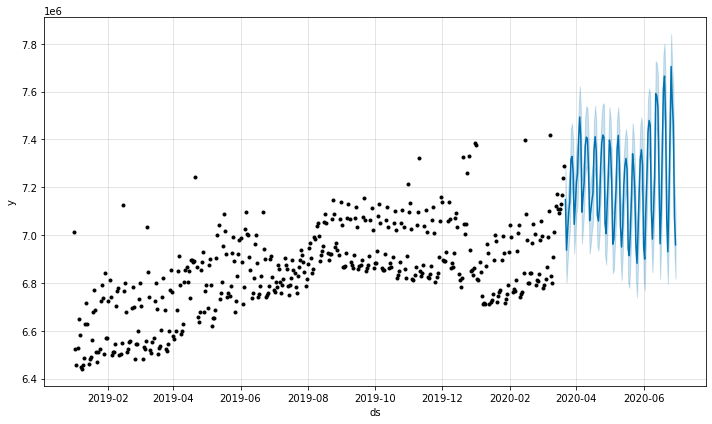

In [ ]:
covid_df2 = covid_df2.rename(columns={'date': 'ds', 'new_cases': 'covid_cases'})

merged_data = pd.merge(my_data2, covid_df2, on='ds', how='left')
merged_data['covid_cases'] = merged_data['covid_cases'].fillna(0)

model = Prophet()
model.add_regressor('covid_cases')
model.fit(merged_data)

historical_predictions = model.predict(merged_data)

future = pd.DataFrame({'ds': pd.date_range(start='2020-03-22', end='2020-06-30')})
future_covid_data = covid_df2[covid_df2['ds'].dt.year == 2020]
future = pd.merge(future, future_covid_data, on='ds', how='left')
future['covid_cases'] = future['covid_cases'].fillna(0)

forecast = model.predict(future)

model.plot(forecast);

In [ ]:
forecast_q2 = forecast[forecast['ds'].between("2020-04-01", "2020-6-30")]
forecast_q2["yhat"].mean()

7233556.730060689

Q2'2020 DAU Upper Bound: 7,233,556.73

Forecasted Average Q2'2020 DAU Range: (6977934.72, 7233556.73)

# <center> Covid's Impact on Snapchat Engagement </center>

### First Covid Case by Country

Sweden - January 30th, 2020
https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Sweden

Norway - February 26th, 2020
https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Norway

Denmark - February 27th, 2020
https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Denmark


### Sweden

In [ ]:
sweden = my_data[my_data['Country'] == "SE"]
sweden = sweden.groupby(['Event_Date'], as_index = False).sum()

sweden_before = sweden[sweden['Event_Date'].between("2019-01-01", "2020-01-29")]
sweden_after = sweden[sweden['Event_Date'].between("2019-01-30", "2020-03-21")]

In [ ]:
sweden_after.mean() - sweden_before.mean()

<ipython-input-45-bbfa02b186c2>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  sweden_after.mean() - sweden_before.mean()


Age                      -526.299
Daily_Active_Users       5129.812
Daily_Total_Users      882851.962
Daily_Unique_Snaps       3979.577
Daily_Total_Snaps      342046.984
Daily_Unique_Sends       3068.225
Daily_Total_Sends      290405.566
Daily_Unique_Stories    -1578.152
Daily_Total_Stories     -4484.539
dtype: float64

In Sweden, average daily active users and average daily snapchats sent were higher after the first covid case was reported in the country than they were before. Average stories posted was lower.

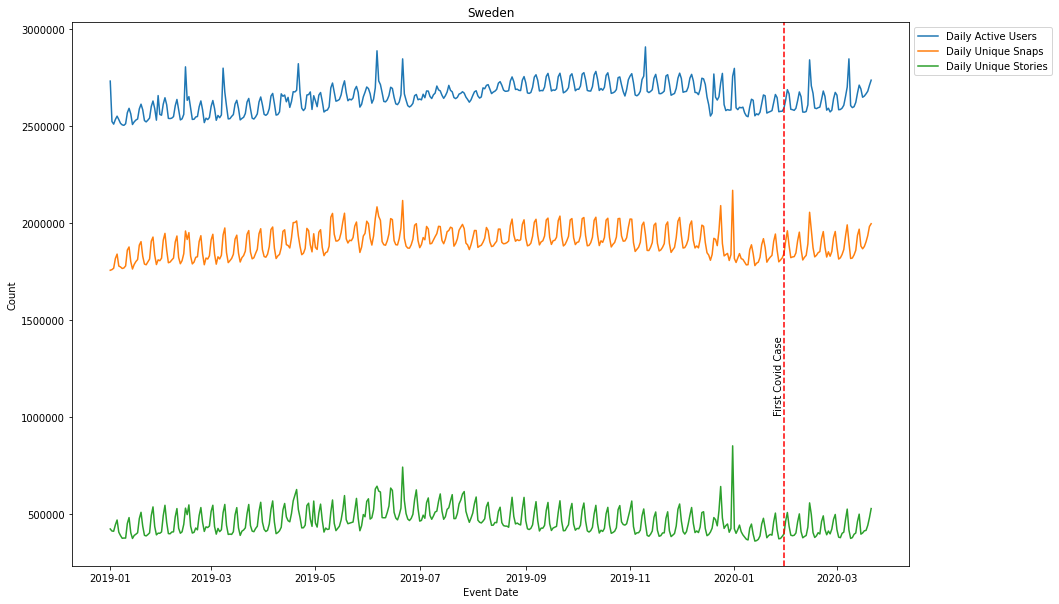

In [ ]:
sweden['Event_Date'] = pd.to_datetime(sweden['Event_Date'])

my_plot = sweden.groupby(['Event_Date'], as_index=False).sum()

vertical_date = pd.to_datetime('2020-01-30')

fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='Event_Date', y='Daily_Active_Users', data=my_plot, ax=ax, label='Daily Active Users')
sns.lineplot(x='Event_Date', y='Daily_Unique_Snaps', data=my_plot, ax=ax, label='Daily Unique Snaps')
sns.lineplot(x='Event_Date', y='Daily_Unique_Stories', data=my_plot, ax=ax, label='Daily Unique Stories')

ax.axvline(x=vertical_date, color='red', linestyle='--')
ax.text(vertical_date, ax.get_ylim()[1]*0.4, 'First Covid Case', rotation=90, ha='right', va='center', transform=ax.transData)

ax.set_xlabel('Event Date')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

ax.legend(['Daily Active Users', 'Daily Unique Snaps', 'Daily Unique Stories'])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Sweden')
plt.show()

### Norway

In [ ]:
norway = my_data[my_data['Country'] == "NO"]
norway = norway.groupby(['Event_Date'], as_index = False).sum()

norway_before = norway[norway['Event_Date'].between("2019-01-01", "2020-02-26")]
norway_after = norway[norway['Event_Date'].between("2020-02-27", "2020-03-21")]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
norway_after.mean() - norway_before.mean()

<ipython-input-48-db05a68dcc82>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  norway_after.mean() - norway_before.mean()


Age                       -1543.947
Daily_Active_Users       100045.972
Daily_Total_Users      11298300.788
Daily_Unique_Snaps        64145.263
Daily_Total_Snaps       8476041.200
Daily_Unique_Sends        69566.913
Daily_Total_Sends       7198206.479
Daily_Unique_Stories       8525.280
Daily_Total_Stories       38896.808
dtype: float64

In Norway, average daily active users, average daily snapchats sent, and average stories posted were all higher after the first covid case was reported in the country than they were before.

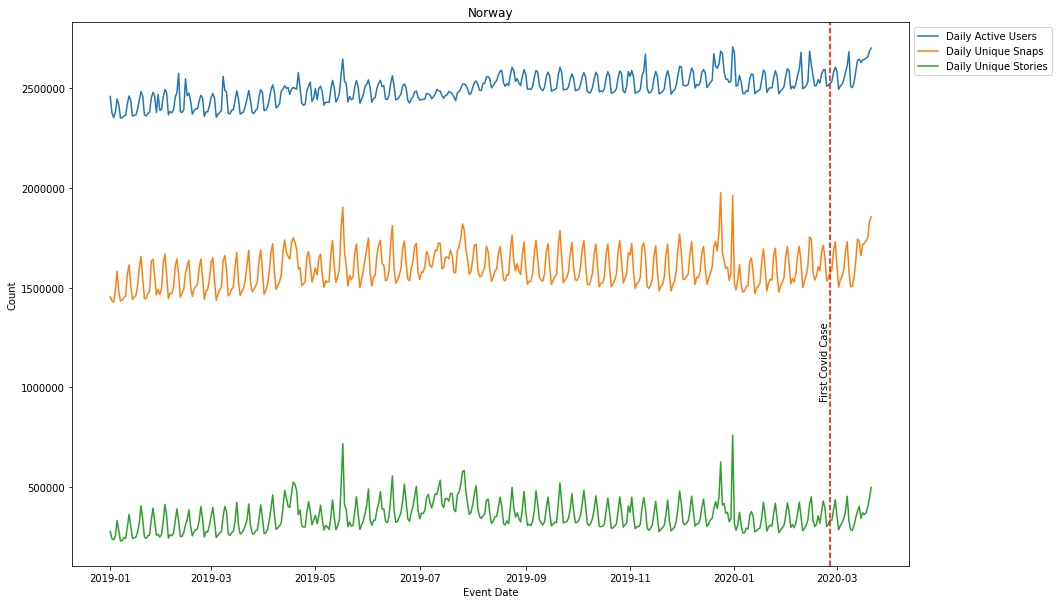

In [ ]:
norway['Event_Date'] = pd.to_datetime(norway['Event_Date'])

my_plot = norway.groupby(['Event_Date'], as_index=False).sum()

vertical_date = pd.to_datetime('2020-02-26')

fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='Event_Date', y='Daily_Active_Users', data=my_plot, ax=ax, label='Daily Active Users')
sns.lineplot(x='Event_Date', y='Daily_Unique_Snaps', data=my_plot, ax=ax, label='Daily Unique Snaps')
sns.lineplot(x='Event_Date', y='Daily_Unique_Stories', data=my_plot, ax=ax, label='Daily Unique Stories')

ax.axvline(x=vertical_date, color='red', linestyle='--')
ax.text(vertical_date, ax.get_ylim()[1]*0.4, 'First Covid Case', rotation=90, ha='right', va='center', transform=ax.transData)

ax.set_xlabel('Event Date')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

ax.legend(['Daily Active Users', 'Daily Unique Snaps', 'Daily Unique Stories'])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Norway')
plt.show()

### Denmark

In [ ]:
denmark = my_data[my_data['Country'] == "DK"]
denmark = denmark.groupby(['Event_Date'], as_index = False).sum()

denmark_before = denmark[denmark['Event_Date'].between("2019-01-01", "2020-02-27")]
denmark_after = denmark[denmark['Event_Date'].between("2020-02-28", "2020-03-21")]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
denmark_after.mean() - denmark_before.mean()

<ipython-input-51-37fe3792d4fb>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  denmark_after.mean() - denmark_before.mean()


Age                       -601.851
Daily_Active_Users       78341.173
Daily_Total_Users      7359852.892
Daily_Unique_Snaps       53702.371
Daily_Total_Snaps      6555201.063
Daily_Unique_Sends       55071.363
Daily_Total_Sends      5726219.549
Daily_Unique_Stories      4247.233
Daily_Total_Stories      86591.968
dtype: float64

In Denmark, average daily active users, average daily snapchats sent, and average stories posted were all higher after the first covid case was reported in the country than they were before.

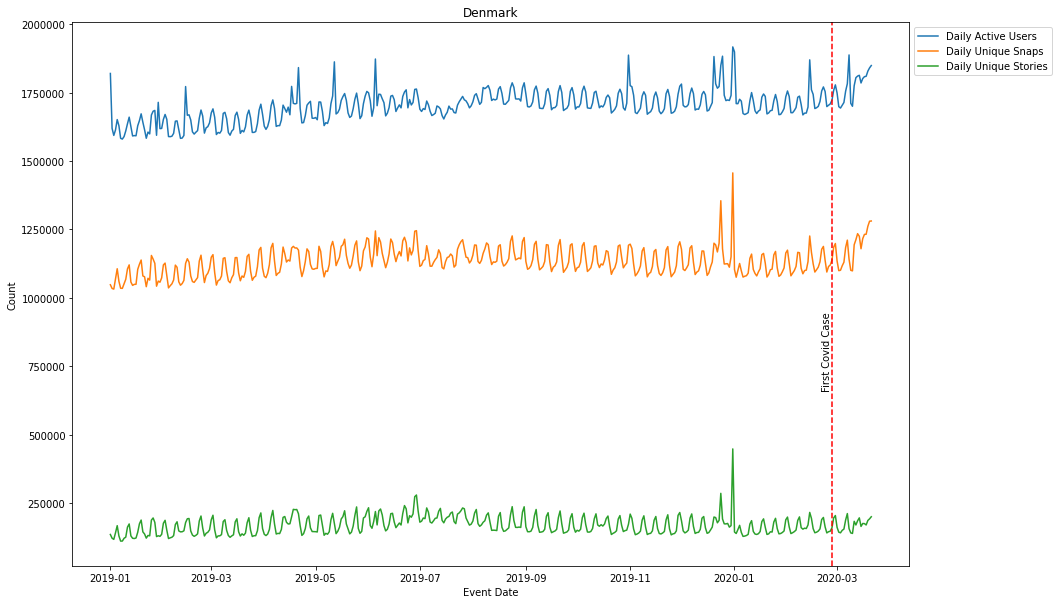

In [ ]:
denmark['Event_Date'] = pd.to_datetime(denmark['Event_Date'])

my_plot = denmark.groupby(['Event_Date'], as_index=False).sum()

vertical_date = pd.to_datetime('2020-02-27')

fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='Event_Date', y='Daily_Active_Users', data=my_plot, ax=ax, label='Daily Active Users')
sns.lineplot(x='Event_Date', y='Daily_Unique_Snaps', data=my_plot, ax=ax, label='Daily Unique Snaps')
sns.lineplot(x='Event_Date', y='Daily_Unique_Stories', data=my_plot, ax=ax, label='Daily Unique Stories')

ax.axvline(x=vertical_date, color='red', linestyle='--')
ax.text(vertical_date, ax.get_ylim()[1]*0.4, 'First Covid Case', rotation=90, ha='right', va='center', transform=ax.transData)

ax.set_xlabel('Event Date')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

ax.legend(['Daily Active Users', 'Daily Unique Snaps', 'Daily Unique Stories'])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_title('Denmark')
plt.show()


# <center> Final Remarks </center>

Denmark and Norway reacted to the covid pandemic by swiftly implementing lockdowns and comprehensive testing programs. Sweden on the other hand, took a different approach and opted not to implement a full lockdown and instead relied on voluntary measures to slow the spread of the virus. Schools remained open, as did many businesses, but large gatherings were prohibited. Although there were only recommendations and not mandates, Swedes complied and respected the social distancing and stay at home suggestions. This resulted in a lot of people being home and having more time to spend on social media. People were bored and lonely, so means of communication with friends and family became essential for mental well-being. "Snapchat gained 11 million users during the first quarter of 2020, a significant uptick from the 8 million it added last quarter, and well ahead of the company’s expected growth. It now has 229 million daily active users, up 20 percent from last year." According to CEO Evan Spiegel, during covid, Snapchat saw "sustained communication volumes on our service that eclipse the peaks we see during major holiday.” In short, covid had a major impact on snapchat engagement.



